In [2]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import pandas as pd
from numpy.linalg import norm, inv
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import pairwise
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
import hdbscan
import cv2
import os
from operator import itemgetter
from visualization_dimensionality_red_functions import *
from clustering_functions import *
from skeletons_aux_functions import *

# Load files

Load skeletons

In [4]:
data = np.load('skeleton_reconstructed.npy')
# get the frames
frames = data[0, :]
# get the skeletons
skeletons = np.delete(data, 0, axis=0)

data = pd.DataFrame(data.T)
data.rename(columns={0: 'frames'}, inplace=True)

Load outliers

In [5]:
outliers = np.load('outliers.npy')

Load images

In [6]:
folder = 'images_giroslow'
images_path = sorted(os.listdir(folder), key=lambda x: os.path.getmtime(os.path.join(folder, x)))

# Skeletons descriptors

Get angles in joints

In [7]:
angles_matrix = joints_angles_matrix(skeletons, frames)

d:\IST\MEEC\4º Ano\P4\PBD\Projeto\skeletons_aux_functions.py:18: RuntimeWarning: invalid value encountered in double_scalars
  angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
d:\IST\MEEC\4º Ano\P4\PBD\Projeto\skeletons_aux_functions.py:18: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))


Get descriptors

In [8]:
skeletons_descriptors = get_skel_descriptors(angles_matrix, data, frames, outliers)
frames = skeletons_descriptors.index.values.astype(int)
skeletons_descriptors = skeletons_descriptors.values.T

# Center data 

In [9]:
skeletons_descriptors_cnt, scaler = data_centering(skeletons_descriptors, with_std=True)

# Rank and dimensionality reduction

Get rank

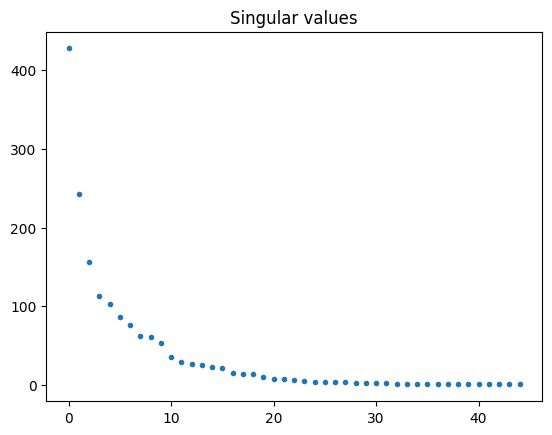

Rank: 8


In [10]:
svd = data_visualization(skeletons_descriptors_cnt, method='svd', n_components=skeletons_descriptors_cnt.shape[0])

# Calculate the rank of the features
cum_var = np.cumsum(svd.explained_variance_ratio_)
rank = np.where(cum_var > 0.95)[0][0] + 1
print('Rank:', rank)

Visualize dimensionality reduction with PCA

In [13]:
embedding_PCA = data_visualization(skeletons_descriptors, method='pca', n_components=3)

Visualize dimensionality reduction with TSNE

In [14]:
embedding_TSNE = data_visualization(skeletons_descriptors, method='tsne', n_components=3, n_neighbors=15)

c:\Users\duart\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Visualize dimensionality reduction with UMAP

In [15]:
embedding_UMAP = data_visualization(skeletons_descriptors_cnt, method='umap', n_components=3, n_neighbors=15)

Get reduced data

In [16]:
# use UMAP to reduce dimensionality
embeddings = dimensionality_reduction(skeletons_descriptors_cnt, method='umap', n_components=rank, n_neighbors=15)

Center reduced data

In [17]:
embeddings_centered = data_centering(embeddings)[0]

# Similarity matrix

Get similarity matrix

In [95]:
similarity_type = 4 # 1 for cosine and unreduced data, 2 for euclidean and unreduced data, 3 for cosine and reduced data, 4 for euclidean and reduced data

if similarity_type == 1:
    similarity_matrix = get_similarity_matrix(skeletons_descriptors_cnt, similarity='cosine')
elif similarity_type == 2:
    similarity_matrix = get_similarity_matrix(skeletons_descriptors_cnt, similarity='euclidean')
elif similarity_type == 3:
    similarity_matrix = get_similarity_matrix(embedding_UMAP, similarity='cosine')
elif similarity_type == 4:
    similarity_matrix = get_similarity_matrix(embedding_UMAP, similarity='euclidean')


Similarity matrix histogram

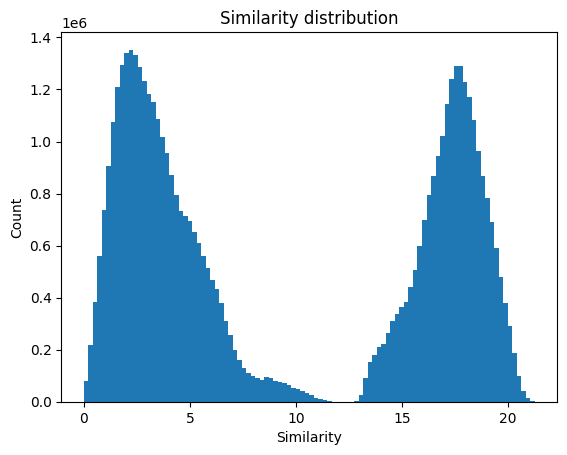

In [96]:
similarity_matrix_hist(similarity_matrix)

Get epsilon for DBSCAN 

In [100]:
eps = float(np.quantile(similarity_matrix, 0.002))
print('Eps:', eps)

Eps: 0.2414247989654541


# DBSCAN Clustering

In [101]:
dbscan_clusterer = clusterer_function(method='DBSCAN', similarity_matrix=similarity_matrix, precomputed=True, min_samples=3, eps=eps)

Clusters sizes histogram

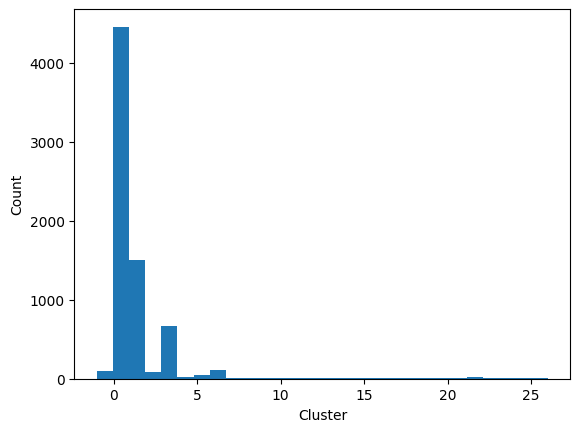

Number of clusters: 28
Highest number of elements in a clusters: 4454
Smallest number of elements in a clusters: 3


In [104]:
cluster_size_hist(dbscan_clusterer)

Unlabeled frames 

In [106]:
unlabeled = np.where(dbscan_clusterer.labels_ == -1)[0]
print('Number of unlabeled frames:', len(unlabeled))

Number of unlabeled frames: 97


Unlabeled frames visualization

In [108]:
visualization_w_images( cluster=frames[unlabeled], folder= folder, images_path=images_path)

Create cluster dictionary

In [109]:
dbscan_cluster_dict = {}
for i in np.unique(dbscan_clusterer.labels_):
    if i != -1: # ignore unlabled frames
        dbscan_cluster_dict[i] = np.where(dbscan_clusterer.labels_ == i)[0]

Visualization of some random clusters

In [110]:
clusters = np.random.choice(list(dbscan_cluster_dict.keys()), 4, replace=False)
for cluster in clusters:
    visualization_w_images(cluster = frames[dbscan_cluster_dict[cluster]], folder= folder, images_path=images_path) # press q to exit to next cluster

As it can be seen above DBSCAN is not able to cluster the data correctly. The reason being that the data is not well separated neither the original data nor the reduced data. Given this it does not make sense to continue with the analysis and merge similar clusters.

Get bases for clusters and Compute NSI matrix

In [ ]:
bases, sv = get_bases(dbscan_cluster_dict, skeletons_descriptors_cnt)
clusters_singular_values_plot(sv)
NSI_matrix = compute_NSI(dbscan_cluster_dict, bases, sv)
sns.histplot(NSI_matrix.flatten(), bins=20)
plt.xlabel('NSI')

Visualize sparse NSI matrix

In [ ]:
threshold = 0.3
plt.spy(NSI_matrix+NSI_matrix.T, precision= threshold)

Merge clusters

In [ ]:
hdbscan_cluster_dict, NSI_matrix = final_cluster_merger(hdbscan_cluster_dict, skeletons_descriptors_cnt, NSI_matrix, threshold)

Visualize random cluster

In [ ]:
visualization_w_images(cluster = frames[dbscan_cluster_dict[np.random.choice(list(dbscan_cluster_dict.keys()))]], folder= folder, images_path=images_path)

# KMeans clustering

In [111]:
KMeans_clusterer = clusterer_function(method='KMeans',data=skeletons_descriptors_cnt, n_clusters=20)

Clusters sizes histogram

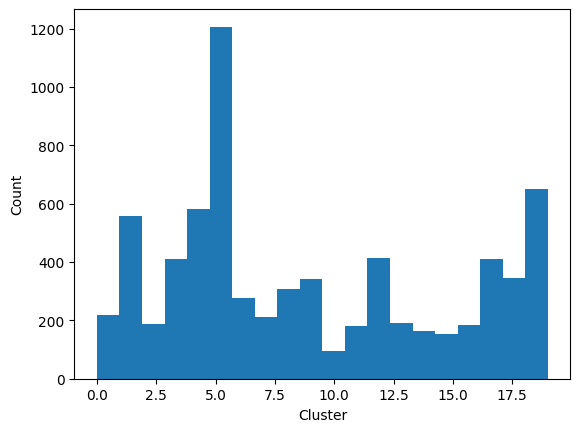

Number of clusters: 20
Highest number of elements in a clusters: 1207
Smallest number of elements in a clusters: 0


In [112]:
cluster_size_hist(KMeans_clusterer)

Create cluster dictionary

In [113]:
KMeans_cluster_dict = {}
for i in np.unique(KMeans_clusterer.labels_):
        KMeans_cluster_dict[i] = np.where(KMeans_clusterer.labels_ == i)[0]

Visualization of some random cluster

In [114]:
clusters = np.random.choice(list(KMeans_cluster_dict.keys()), 4, replace=False)
for cluster in clusters:
    visualization_w_images(cluster = frames[KMeans_cluster_dict[cluster]], folder= folder, images_path=images_path) # press q to exit to next cluster

Once again the clustering is not able to separate the data correctly. Given this it does not make sense to continue with the analysis and merge similar clusters.

Get bases for clusters and Compute NSI matrix

In [ ]:
bases, sv = get_bases(KMeans_cluster_dict, skeletons_descriptors_cnt)
clusters_singular_values_plot(sv)
NSI_matrix = compute_NSI(KMeans_cluster_dict, bases, sv)
sns.histplot(NSI_matrix.flatten(), bins=20)

Visualize sparse NSI matrix

In [ ]:
threshold = 0.79
plt.spy(NSI_matrix+NSI_matrix.T, precision= threshold)

Merge clusters

In [ ]:
KMeans_cluster_dict, NSI_matrix = final_cluster_merger(KMeans_cluster_dict, skeletons_descriptors_cnt, NSI_matrix, threshold)

Visualize random cluster

In [ ]:
visualization_w_images(cluster = frames[KMeans_cluster_dict[np.random.choice(list(KMeans_cluster_dict.keys()))]], folder= folder, images_path=images_path)